Opening raw data file Risultati/data_raw.fif...
Isotrak not found
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.
Reading 0 ... 57727  =      0.000 ...   225.496 secs...


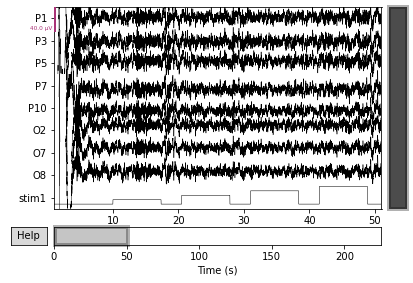

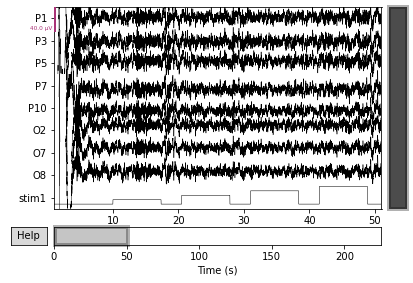

In [1]:
import mne
from mne.preprocessing import (ICA)

raw = mne.io.read_raw_fif("Risultati/data_raw.fif", preload = True)
raw.plot(start=1, duration=50)

# Raw

In [2]:
raw_eeg = raw.pick_types(eeg=True)
raw_eeg

<Raw | data_raw.fif, 8 x 57728 (225.5 s), ~3.5 MB, data loaded>

# Filt + ICA

In [3]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.4s.
Creating RawArray with float64 data, n_channels=8, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


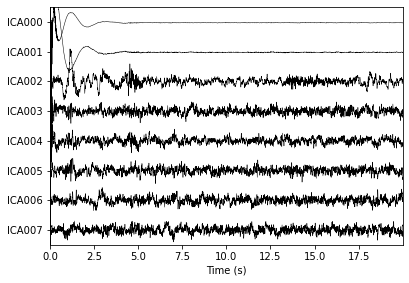

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 57728 (225.5 s), ~3.5 MB, data loaded>

In [4]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [5]:
filt_ICA = reconst_raw.copy()

# Filt + CAR

In [6]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



In [7]:
avg_ref = filt_eeg.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [8]:
filt_CAR = avg_ref.copy()

# Filt + ICA + CAR

In [9]:
filt_eeg = raw_eeg.filter(l_freq=1,h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.2s.
Creating RawArray with float64 data, n_channels=8, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


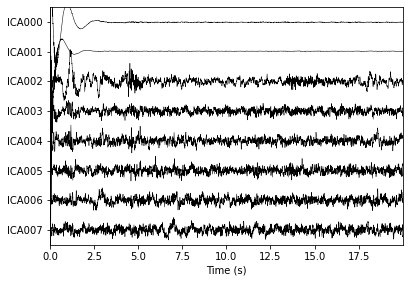

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 57728 (225.5 s), ~3.5 MB, data loaded>

In [10]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [11]:
avg_ref = reconst_raw.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [12]:
filt_ica_car = avg_ref.copy()